# Imports

In [4]:
from skimage import filters
from skimage import io, color
import numpy as np
from scipy.ndimage import convolve, maximum_filter
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #avoid annoying imshow deprecated
import math
from typing import Literal
from tqdm import tqdm
import torch
from transformers import pipeline


import utils

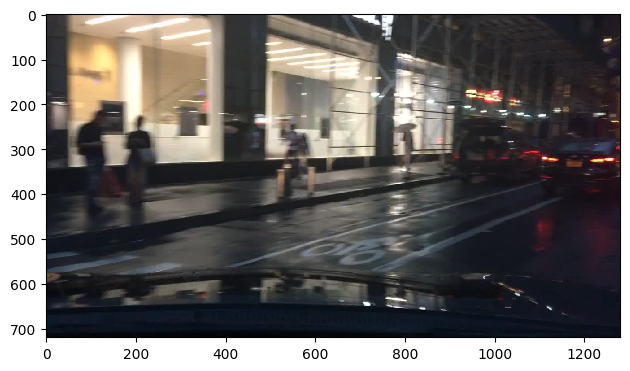

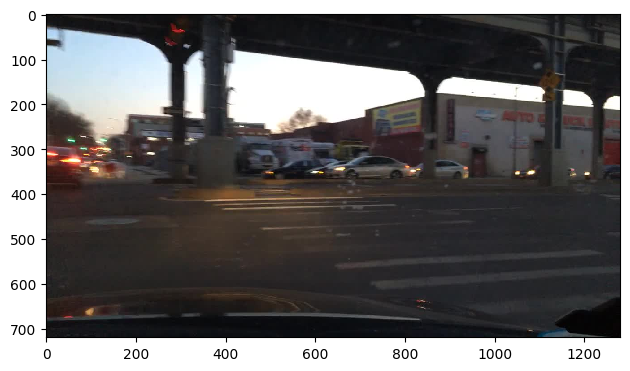

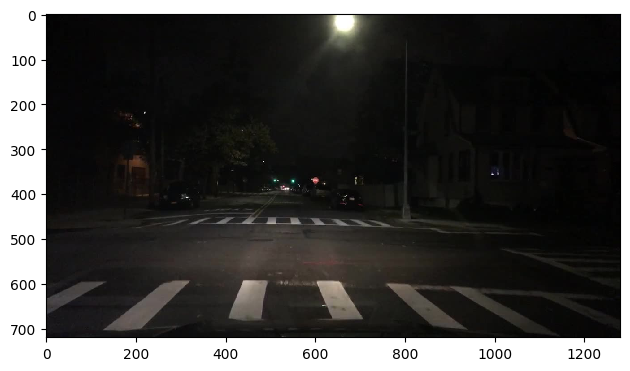

In [5]:
sample_images = utils.get_sample_images()
utils.plot_sample_images(sample_images[:3])

In [6]:
sample_img = sample_images[1]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


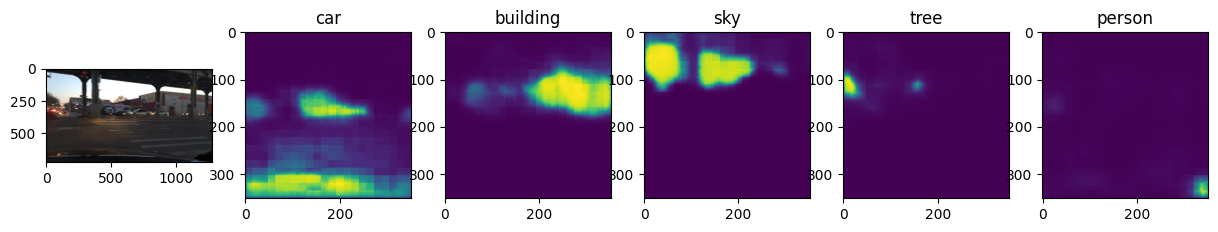

In [7]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import torch
from PIL import Image
import requests

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

prompts = ["car", "building", "sky", "tree", "person"]

inputs = processor(text=prompts, images=[sample_img] * len(prompts), return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

preds = outputs.logits.unsqueeze(1)

import matplotlib.pyplot as plt
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(15, 4))
ax[0].imshow(sample_img)
for i, prompt in enumerate(prompts):
    ax[i+1].imshow(torch.sigmoid(preds[i][0]))
    ax[i+1].set_title(prompt)
plt.show()

In [8]:
from PIL import Image
sample_img = Image.open('sample_images/f702ebe5-679718ad.jpg')

Device set to use cpu
`label_ids_to_fuse` unset. No instance will be fused.


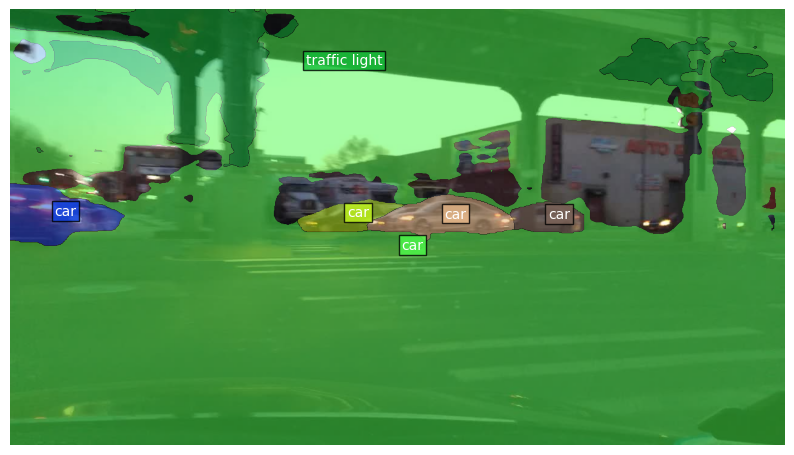

In [10]:
instance_segmenter = pipeline("image-segmentation", model="facebook/mask2former-swin-tiny-coco-instance", device=-1)

# Run
outputs = instance_segmenter(sample_img)

def overlay_masks(image, outputs):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    
    # Sort by size so small objects are drawn on top of large ones (like 'wall' or 'floor')
    outputs = sorted(outputs, key=lambda x: np.array(x['mask']).sum(), reverse=True)

    for item in outputs:
        mask = np.array(item['mask'])
        label = item['label']
        
        # Create a random color with transparency
        color = np.concatenate([np.random.random(3), [0.5]])
        
        # The mask is boolean (0 or 255). We make it an RGBA overlay.
        h, w = mask.shape
        mask_image = np.zeros((h, w, 4))
        mask_image[mask > 0] = color
        
        ax.imshow(mask_image)
        
        # Add a label at the center of mass
        ys, xs = np.where(mask > 0)
        if len(xs) > 0:
            cy, cx = int(np.mean(ys)), int(np.mean(xs))
            ax.text(cx, cy, label, color='white', fontsize=10, 
                    bbox={'facecolor': color[:3], 'alpha': 0.8, 'pad': 2})

    plt.axis('off')
    plt.show()

# Reuse the same visualization function from above
overlay_masks(sample_img, outputs)

Device set to use cpu


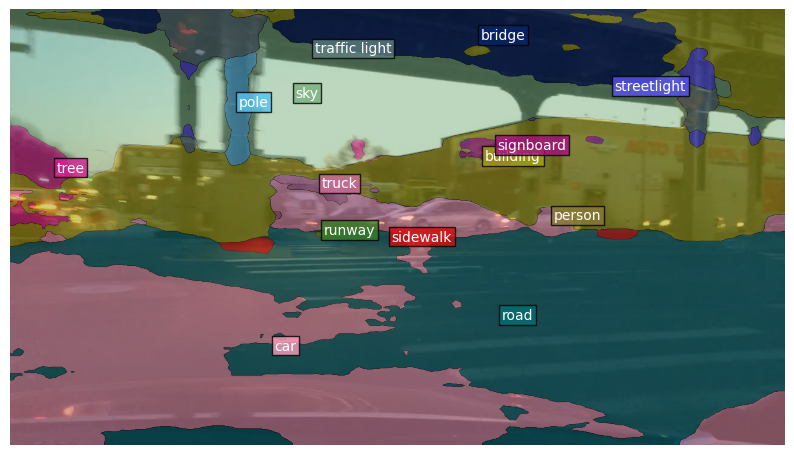

In [12]:
segmenter = pipeline("image-segmentation", model="nvidia/segformer-b0-finetuned-ade-512-512", device=-1)


outputs = segmenter(sample_img)
overlay_masks(sample_img, outputs)